In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx 
import time
import random

In [3]:
dff = pd.read_csv("games.csv") #read from CSV File 
dff.dropna(inplace=True) #dropping rows containing nan data
dff.drop(dff.columns[0],axis = 1,inplace = True)
dff.astype(int) #convert boolean (win column) to int  True False to (0,1)
dff = dff.drop_duplicates(subset ='gameId') #Drop rows that are redundant based on the gameId column
dff.reset_index(drop=True,inplace=True) #Reindex the DataFrame after dropping rows

In [4]:
playersMap = dict() #mapping each player to their number of games 
for index, row in dff.iterrows():
    for playerNum in range(1,6):
        for teamNum in range(1,3):
            column = "Team" + str(teamNum) + "_summonerId_" + str(playerNum)
            playerId = dff.loc[index,column]
            if playerId != 0:
                playerId = int(playerId)
                if playerId in playersMap:
                    count = playersMap[playerId]
                    count +=1
                    playersMap[playerId] = count
                else:
                    playersMap[playerId] = 1

In [5]:
selectedPlayers = set() # putting players that played more than 10 games in a set 
for key,value in playersMap.items():
    if value>10:
        selectedPlayers.add(key)

In [6]:
# creating a dictionary for each of the selected players. This dictionary includes the Ids of opponent players along with the scores 
dfInt = dff.astype(int)
playedAgainst = {}
for index, row in dfInt.iterrows():
    team1 = set()
    team2 = set()
    team1Info = dict()
    team2Info = dict()
    for playerNum in range(1,6):#constant loop
        for teamNum in range(1,3):#constant loop
            column = "Team" + str(teamNum) + "_summonerId_" + str(playerNum)
            playerId = dfInt.loc[index,column]
            if playerId in selectedPlayers:
                if teamNum == 1:
                    team1.add(playerId)
                else:
                    team2.add(playerId)
    # map each player of a team to the ids of opponent players
    for player in team1: 
        if player in playedAgainst:
            for opponent in team2:
                if opponent in playedAgainst[player]:
                    lst = playedAgainst[player][opponent]
                    lst.append(row['Team1_win'])
                    playedAgainst[player][opponent] = lst
                else:
                    playedAgainst[player][opponent] = [row['Team1_win']]
        else:
            scores = dict()
            for opponent in team2:#player scores against team2
                scores[opponent] = [row['Team1_win']]
            playedAgainst[player] = scores
    for player in team2: 
        if player in playedAgainst:
            for opponent in team1:
                if opponent in playedAgainst[player]:
                    lst = playedAgainst[player][opponent]
                    lst.append(row['Team2_win'])                        
                    playedAgainst[player][opponent] = lst
                else:
                     playedAgainst[player][opponent] = [row['Team2_win']]               
        else:
            scores = dict()
            for opponent in team1:#player scores against team2
                scores[opponent] = [row['Team2_win']]
            playedAgainst[player] = scores

In [7]:
#removing scores based on one game only..
for key,val in playedAgainst.items():
    for k,v in val.items():
        if len(v)<2:
            playedAgainst[key].pop(k, None)

In [8]:
#Creating cliques that represent relations between players A,B,C
cliques = list()
for playerA,val in playedAgainst.items(): #Player A
    p = list()
    for playerB in val:
        if playerB in playedAgainst: # if opponent has a set of other opponents, PlayerB
            for playerC in playedAgainst[playerB]: #find B's opponent C that had also played A 
                if playerC in val:
                    p.append(playerA)
                    p.append(playerB)
                    p.append(playerC)
                    cliques.append(p[:])
                    del p[:]

In [9]:
def bootstrap(iterations, data,conf): #conf is the confidence percentage in decimal form
    data = np.array(data)
    samples  = np.random.choice(data,replace = True, size = [iterations, len(data)])
    vals = []
    for sample in samples:
        sta = np.mean(sample)
        vals.append(sta)
    intervals = np.array(vals)
    a = (1-conf)/2
    b = 1-a
    a = a*100
    b = b*100
#     print a,'a'
#     print b,'b'
    lower, upper = np.percentile(intervals, [a, b])
    CI = intervals[(intervals >=lower) & (intervals <=upper)]
    if 0.5 not in CI: 
        return data.mean()
    else:
        return 0.5

In [10]:
def detectIntrans(AB,BC,CA): #AB,BC,CA
    G=nx.DiGraph()
    if(AB>0.5):
        G.add_edge("A","B")
    else:
        G.add_edge('B','A')
    if(BC>0.5):
        G.add_edge('B','C')
    else:
        G.add_edge('C','B')
    if(CA>0.5):
        G.add_edge('C','A')
    else:    
        G.add_edge("A",'C')
    
    #If there is a node without predecessor then it is transitive, else intransitive  
    intransitive = True
    for node in G.nodes():
        if not G.predecessors(node):
            intransitive = False        
    return intransitive,G            

In [24]:
start_time = time.time()
def findIntransitivities(cliques,playedAgainst,numOfsamples,conf):
    intransitivies  = []
    transitives = []
    undecided = []
    for clique in cliques:
        scoresAB = list()
        scoresBC = list()
        scoresCA = list()
        if clique[0] in playedAgainst:
            A_opponents = playedAgainst[clique[0]]
            if clique[1] in A_opponents:
                scoresAB = A_opponents[clique[1]]      #scores for player A>B
        if clique[1] in playedAgainst:
            B_opponents = playedAgainst[clique[1]]
            if clique[2] in B_opponents:
                scoresBC = B_opponents[clique[2]]      #scores for player A>B        
        if clique[2] in playedAgainst:
            C_opponents = playedAgainst[clique[2]]
            if clique[0] in C_opponents:
                    scoresCA = C_opponents[clique[0]]      #scores for player C>A    
        boots=[]
        bootABMean = bootstrap(numOfsamples,scoresAB,conf)
        bootBCMean = bootstrap(numOfsamples,scoresBC,conf)
        bootCAMean = bootstrap(numOfsamples,scoresCA,conf)
        boots.append(bootABMean)
        boots.append(bootBCMean)
        boots.append(bootCAMean)   
        if 0.5 in boots:
            undecided.append(clique)
        else:
            detTrans = detectIntrans(bootABMean,bootBCMean,bootCAMean)
            isTrans = detTrans[0]
            G = detTrans[1]
            if isTrans:
                intransitivies.append([clique,G])
            else: #for transative relations
                transitives.append([clique,G])
    return intransitivies,transitives,undecided
end_time = time.time()
diff_time = end_time - start_time

In [12]:
def drawNetworKGraphs(samples,intrasitives):
    for i in range(0,samples):
        sampleIndex = np.random.randint(0,len(intrasitives)) #randomlly pick an intransative relation to print
        sample = intrasitives[sampleIndex]
        G = sample[1]
        print 'Players Ids ', sample[0]
        nx.draw(G, node_color='cc',edge_color='k', with_labels=True)
        plt.show()

In [41]:
start_time = time.time()
relations = findIntransitivities(cliques,playedAgainst,1000,0.95)
end_time = time.time()
diff_time = end_time - start_time
print 'time taken ', diff_time

time taken  446.396192074


In [27]:
intrasitives = relations[0]
transitives = relations[1]
undecided = relations[2]

Players Ids  [22107301, 20717177, 19151853]


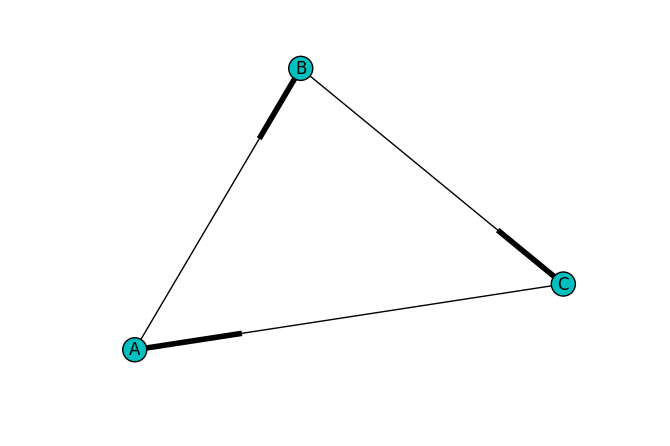

Players Ids  [96197841, 42256924, 42829492]


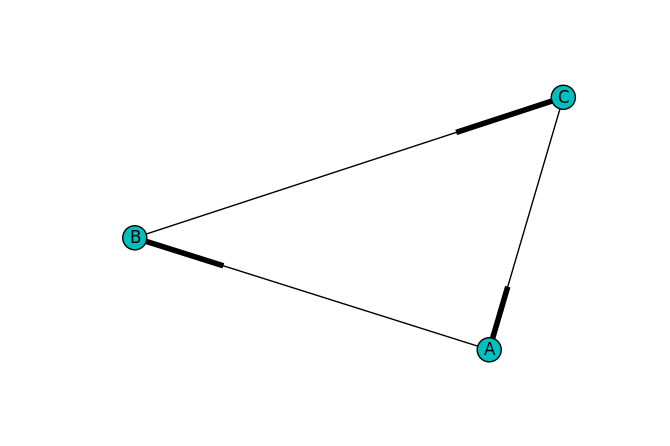

Players Ids  [42287489, 36467479, 32317426]


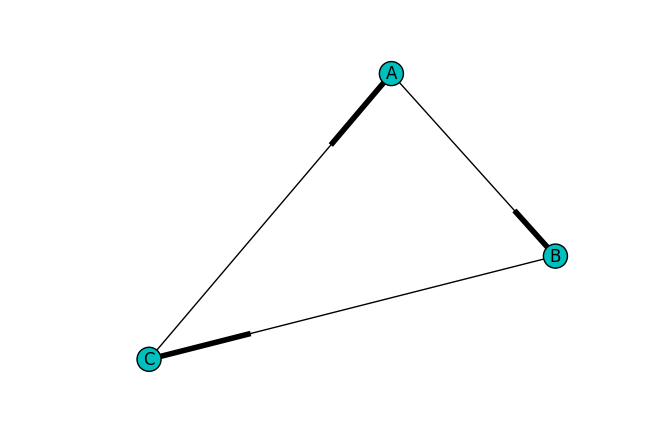

Players Ids  [94418904, 27361426, 20053332]


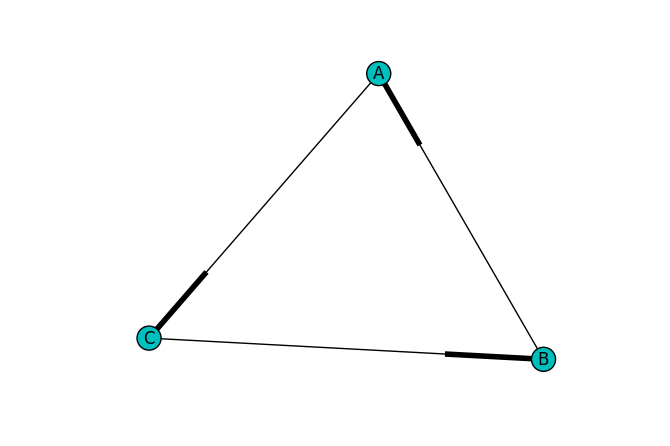

Players Ids  [94987702, 61666806, 20537397]


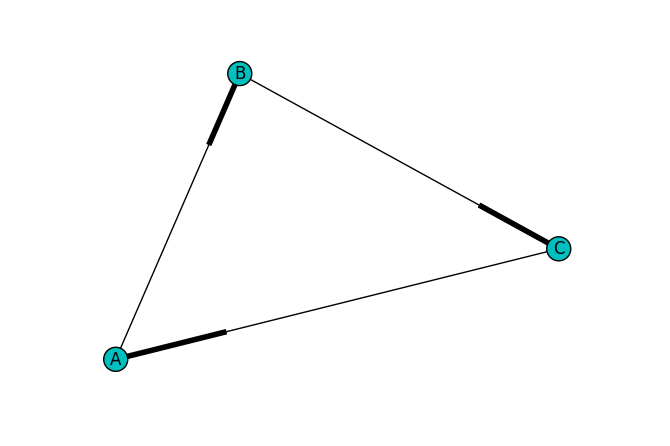

In [15]:
drawNetworKGraphs(5,intrasitives)

In [28]:
print 'Intransitive relations', len(intrasitives)
print 'Transitive relations', len(transitives)
print 'Undecided', len(undecided)

Intransitive relations 660
Transitive relations 3342
Undecided 13944


In [32]:
relations_95_100 = findIntransitivities(cliques,playedAgainst,100,0.95)

In [34]:
intrasitives_95_100 = relations_95_100[0]
transitives_95_100 = relations_95_100[1]
undecided_95_100 = relations_95_100[2]
print 'Intransitive relations, 100 samples 95% conf', len(intrasitives_95_100)
print 'Transitive relations, 100 samples 95% conf', len(transitives_95_100)
print 'Undecided, 100 samples 95% conf', len(undecided_95_100)

Intransitive relations, 100 samples 95% conf 663
Transitive relations, 100 samples 95% conf 3360
Undecided, 100 samples 95% conf 13923


In [35]:
relations_95_10 = findIntransitivities(cliques,playedAgainst,10,0.95)
intrasitives_95_10 = relations_95_10[0]
transitives_95_10 = relations_95_10[1]
undecided_95_10 = relations_95_10[2]
print 'Intransitive relations, 10 samples 95% conf', len(intrasitives_95_10)
print 'Transitive relations, 10 samples 95% conf', len(transitives_95_10)
print 'Undecided, 10 samples 95% conf', len(undecided_95_10)

Intransitive relations, 10 samples 95% conf 736
Transitive relations, 10 samples 95% conf 3776
Undecided, 10 samples 95% conf 13434


In [29]:
relation2 = findIntransitivities(cliques,playedAgainst,1000,0.8)

In [31]:
intrasitives80_1000 = relation2[0]
transitives80_1000 = relation2[1]
undecided80_1000 = relation2[2]
print 'Intransitive relations, 1000 samples 80% conf', len(intrasitives80_1000)
print 'Transitive relations, 1000 samples 80% conf', len(transitives80_1000)
print 'Undecided, 1000 samples 80% conf', len(undecided80_1000)

Intransitive relations, 1000 samples 80% conf 678
Transitive relations, 1000 samples 80% conf 3480
Undecided, 1000 samples 80% conf 13788


In [36]:
relations_80_100 = findIntransitivities(cliques,playedAgainst,100,0.8)
intrasitives_80_100 = relations_80_100[0]
transitives_80_100 = relations_80_100[1]
undecided_80_100 = relations_80_100[2]
print 'Intransitive relations, 100 samples 80% conf', len(intrasitives_80_100)
print 'Transitive relations, 100 samples 80% conf', len(transitives_80_100)
print 'Undecided, 100 samples 80% conf', len(undecided_80_100)

Intransitive relations, 100 samples 80% conf 678
Transitive relations, 100 samples 80% conf 3482
Undecided, 100 samples 80% conf 13786


In [38]:
relations_80_10 = findIntransitivities(cliques,playedAgainst,10,0.8)
intrasitives_80_10 = relations_80_10[0]
transitives_80_10 = relations_80_10[1]
undecided_80_10 = relations_80_10[2]
print 'Intransitive relations, 10 samples 80% conf', len(intrasitives_80_10)
print 'Transitive relations, 10 samples 80% conf', len(transitives_80_10)
print 'Undecided, 10 samples 80% conf', len(undecided_80_10)

Intransitive relations, 10 samples 80% conf 732
Transitive relations, 10 samples 80% conf 3776
Undecided, 10 samples 80% conf 13438


In [39]:
relations_80_10000 = findIntransitivities(cliques,playedAgainst,10000,0.8)
intrasitives_80_10000 = relations_80_10000[0]
transitives_80_10000 = relations_80_10000[1]
undecided_80_10000 = relations_80_10000[2]
print 'Intransitive relations, 10000 samples 80% conf', len(intrasitives_80_10000)
print 'Transitive relations, 10000 samples 80% conf', len(transitives_80_10000)
print 'Undecided, 10000 samples 80% conf', len(undecided_80_10000)

Intransitive relations, 10000 samples 80% conf 678
Transitive relations, 10000 samples 80% conf 3480
Undecided, 10000 samples 80% conf 13788


In [40]:
start_time = time.time()
relations_95_10000 = findIntransitivities(cliques,playedAgainst,10000,0.95)
intrasitives_95_10000 = relations_95_10000[0]
transitives_95_10000 = relations_95_10000[1]
undecided_95_10000 = relations_95_10000[2]
print 'Intransitive relations, 10000 samples 95% conf', len(intrasitives_95_10000)
print 'Transitive relations, 10000 samples 95% conf', len(transitives_95_10000)
print 'Undecided, 10000 samples 95% conf', len(undecided_95_10000)
end_time = time.time()
diff_time = end_time - start_time
print 'time taken ', diff_time

Intransitive relations, 10000 samples 95% conf 660
Transitive relations, 10000 samples 95% conf 3342
Undecided, 10000 samples 95% conf 13944
time taken  3999.30675888
